### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris
from eofs.iris import Eof

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
971995,351.0,89.0,60.0,351089.0
971996,353.0,89.0,60.0,353089.0
971997,355.0,89.0,60.0,355089.0
971998,357.0,89.0,60.0,357089.0


#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/o3_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/o3prod_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/o3loss_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [9]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/eminox_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/emivoc_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'emivoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [11]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/tas_Amon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [12]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/hus_Amon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/abs550aer_AERmon_IPSL-CM6A-LR-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.4. Import planetary boundary layer height

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/bldep_AERmon_IPSL-CM6A-LR-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'bldep')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
pbl = values.reshape(t*lon*lat,1)
dataset['bldep'] = pbl

#### 3.5. Import eastward wind speed

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/ua_Amon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/va_Amon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 4.1. Import NO${_2}$ photolysis rate

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/jno2_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [18]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/photo1d_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [19]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/lossch4_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/lossco_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/no2_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/no_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/oh_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/h2o_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.5. Import PAN reservoir concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/pan_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [26]:
data = iris.load_cube('/Volumes/Database/CMIP6/IPSL/historical/hno3_AERmon_IPSL-CM5A2-INCA_historical_r1i1p1f1_gr_185001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### We should convert 0-360° into 180°W-180°E scheme

In [27]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3,o3prod,o3loss,eminox,emivoc,tas,...,jno2,photo1d,lossch4,lossco,no2,no,oh,h2o,pan,hno3
0,1.0,-89.0,1.0,911.0,1.112896e-08,43453.781250,29979.425781,0.000000e+00,0.000000e+00,245.660065,...,0.010312,0.000005,1.438867e+00,66282.484375,5.793806e-13,2.436301e-12,1.622832e-14,0.000601,9.204013e-12,7.362101e-12
1,3.0,-89.0,1.0,2911.0,1.113095e-08,43206.917969,29742.955078,0.000000e+00,0.000000e+00,245.469589,...,0.010326,0.000005,1.436088e+00,66020.164062,5.751153e-13,2.436294e-12,1.625344e-14,0.000593,9.202983e-12,7.353802e-12
2,5.0,-89.0,1.0,4911.0,1.113095e-08,43206.917969,29742.955078,0.000000e+00,0.000000e+00,245.469589,...,0.010326,0.000005,1.436088e+00,66020.164062,5.751153e-13,2.436294e-12,1.625344e-14,0.000593,9.202983e-12,7.353802e-12
3,7.0,-89.0,1.0,6911.0,1.113436e-08,42965.996094,29509.332031,0.000000e+00,0.000000e+00,245.264908,...,0.010341,0.000005,1.433408e+00,65769.070312,5.709921e-13,2.436865e-12,1.628631e-14,0.000585,9.203666e-12,7.348445e-12
4,9.0,-89.0,1.0,8911.0,1.113436e-08,42965.996094,29509.332031,0.000000e+00,0.000000e+00,245.264908,...,0.010341,0.000005,1.433408e+00,65769.070312,5.709921e-13,2.436865e-12,1.628631e-14,0.000585,9.203666e-12,7.348445e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971995,-9.0,89.0,60.0,351089.0,1.862602e-08,4275.366211,1351.684570,9.564082e-14,7.891430e-15,243.620117,...,0.000000,0.000000,5.829145e-18,593.311462,8.236894e-11,1.233400e-12,2.574691e-17,0.000543,2.001612e-10,6.540646e-10
971996,-7.0,89.0,60.0,353089.0,1.862602e-08,4275.366211,1351.684570,9.564082e-14,2.050938e-15,243.620117,...,0.000000,0.000000,5.829145e-18,593.311462,8.236894e-11,1.233400e-12,2.574691e-17,0.000543,2.001612e-10,6.540646e-10
971997,-5.0,89.0,60.0,355089.0,1.860374e-08,3114.942627,1375.804565,1.464548e-14,0.000000e+00,243.737411,...,0.000000,0.000000,5.823773e-18,605.016663,8.711863e-11,2.367349e-13,2.630935e-17,0.000547,2.005101e-10,6.568362e-10
971998,-3.0,89.0,60.0,357089.0,1.860374e-08,3114.942627,1375.804565,1.464548e-14,8.804017e-16,243.737411,...,0.000000,0.000000,5.823773e-18,605.016663,8.711863e-11,2.367349e-13,2.630935e-17,0.000547,2.005101e-10,6.568362e-10


#### Calculate the kinetic rates

In [28]:
dataset_adj['k_no_ho2']   = 3.30*10**(-12)*np.exp(270/dataset_adj['tas'])
dataset_adj['k_no_ch3o2'] = 2.30*10**(-12)*np.exp(360/dataset_adj['tas'])
dataset_adj['k_o1d_h2o']  = 1.63*10**(-10)*np.exp(60/dataset_adj['tas'])
dataset_adj['k_o3_ho2']   = 2.03*10**(-16)*(dataset_adj['tas']/300)**4.57*np.exp(693/dataset_adj['tas'])
dataset_adj['k_o3_oh']    = 1.70*10**(-12)*np.exp(-940/dataset_adj['tas'])

#### Calculate the procedural auxilliary variables 
##### where K1's are aggressive approach to use as many associated variables as possible 
##### and K2's are conservative approach to only use variables that we trust the credibility 

In [29]:
dataset_adj['K1_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no'] * dataset_adj['lossco']
dataset_adj['K1_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no'] * dataset_adj['lossch4']
dataset_adj['K1_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3'] * dataset_adj['hus']
dataset_adj['K1_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K1_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3'] * dataset_adj['lossco']

In [30]:
dataset_adj['K2_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no']
dataset_adj['K2_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no']
dataset_adj['K2_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['hus']
dataset_adj['K2_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K2_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3']

In [31]:
dataset_adj.to_csv('/Volumes/Database/Research/C7 Multivariate analysis/IPSL-CM5A2-INCA_diag_2014(0318).csv', index = False)

### Map the variables to ensure correct gridding

(-90.0, 90.0)

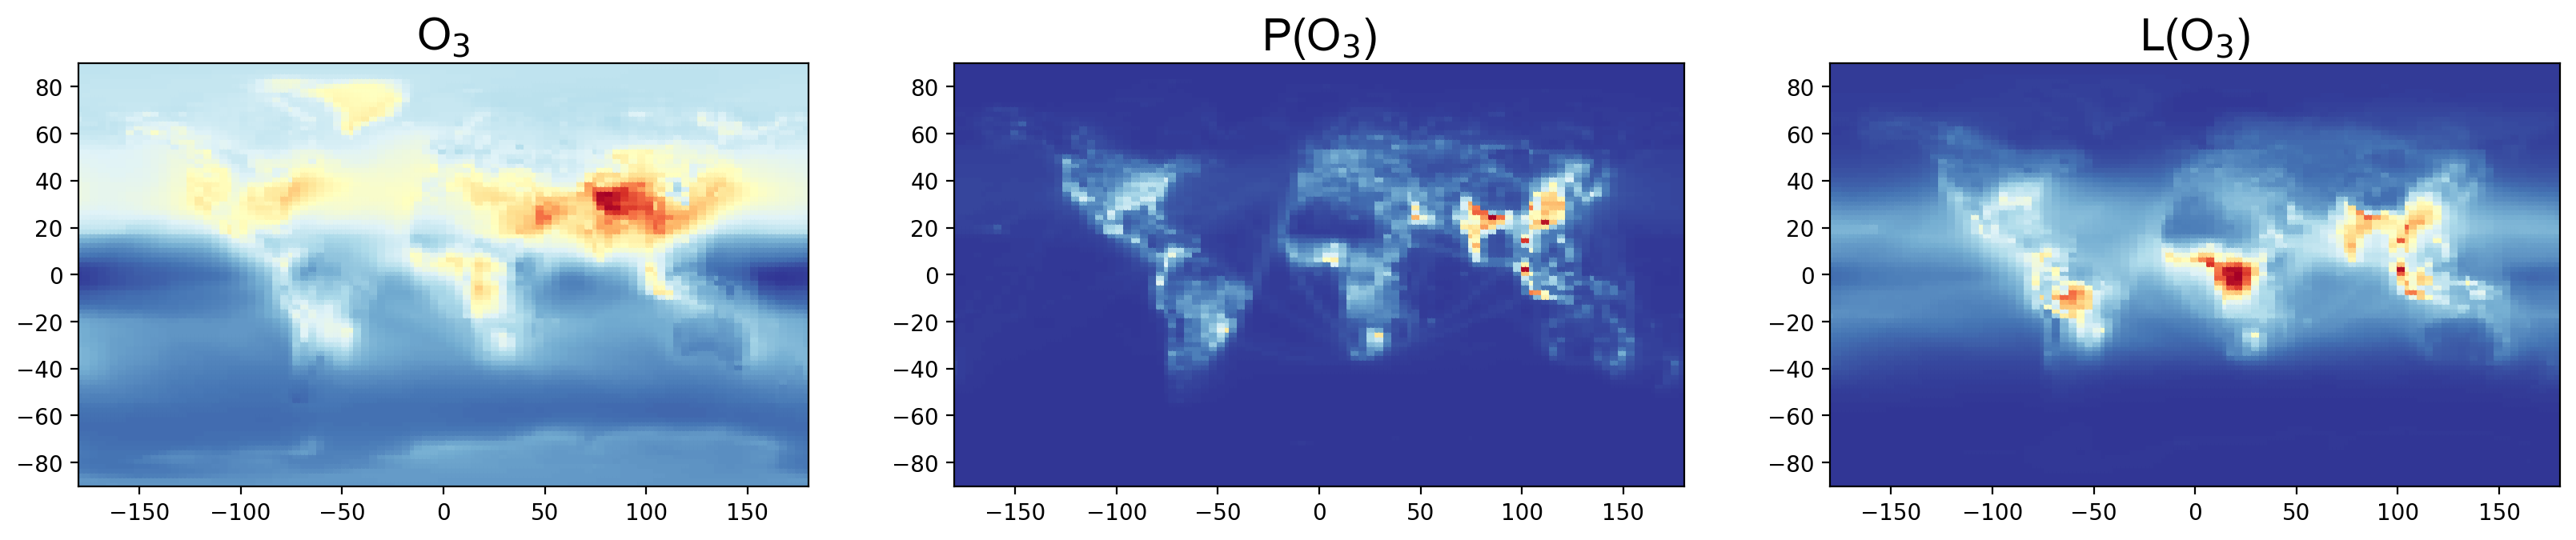

In [32]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

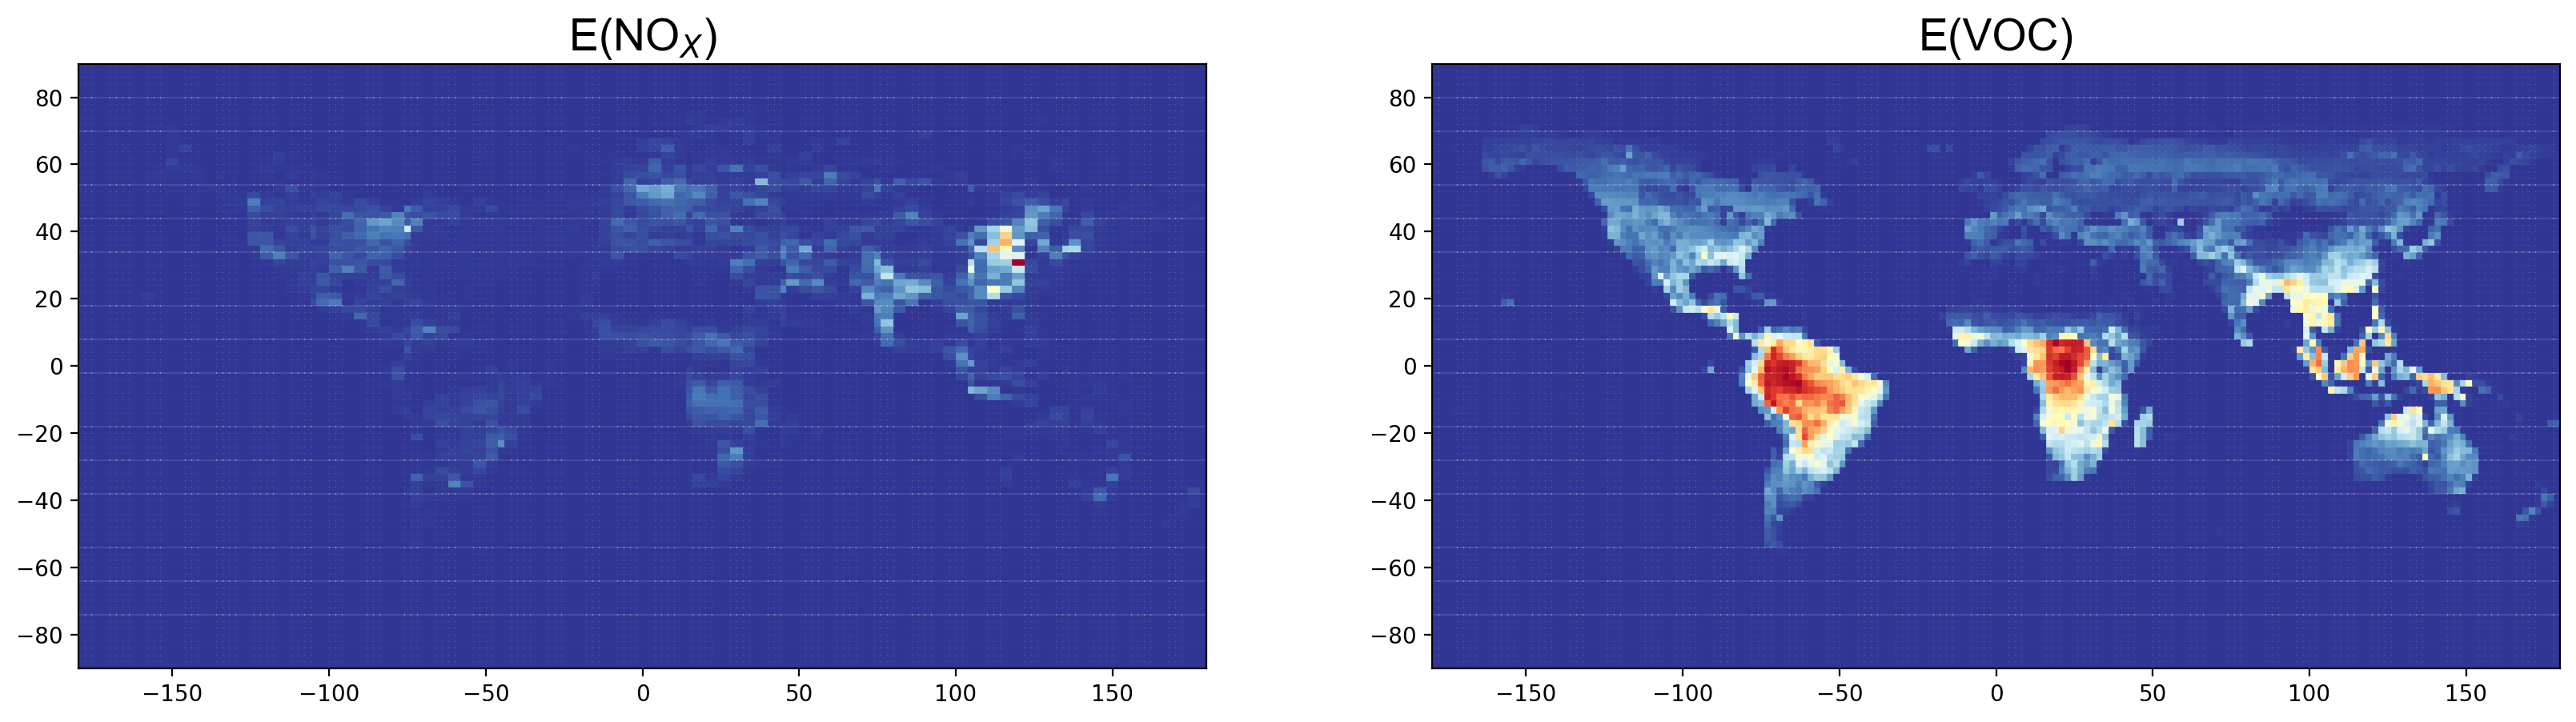

In [33]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

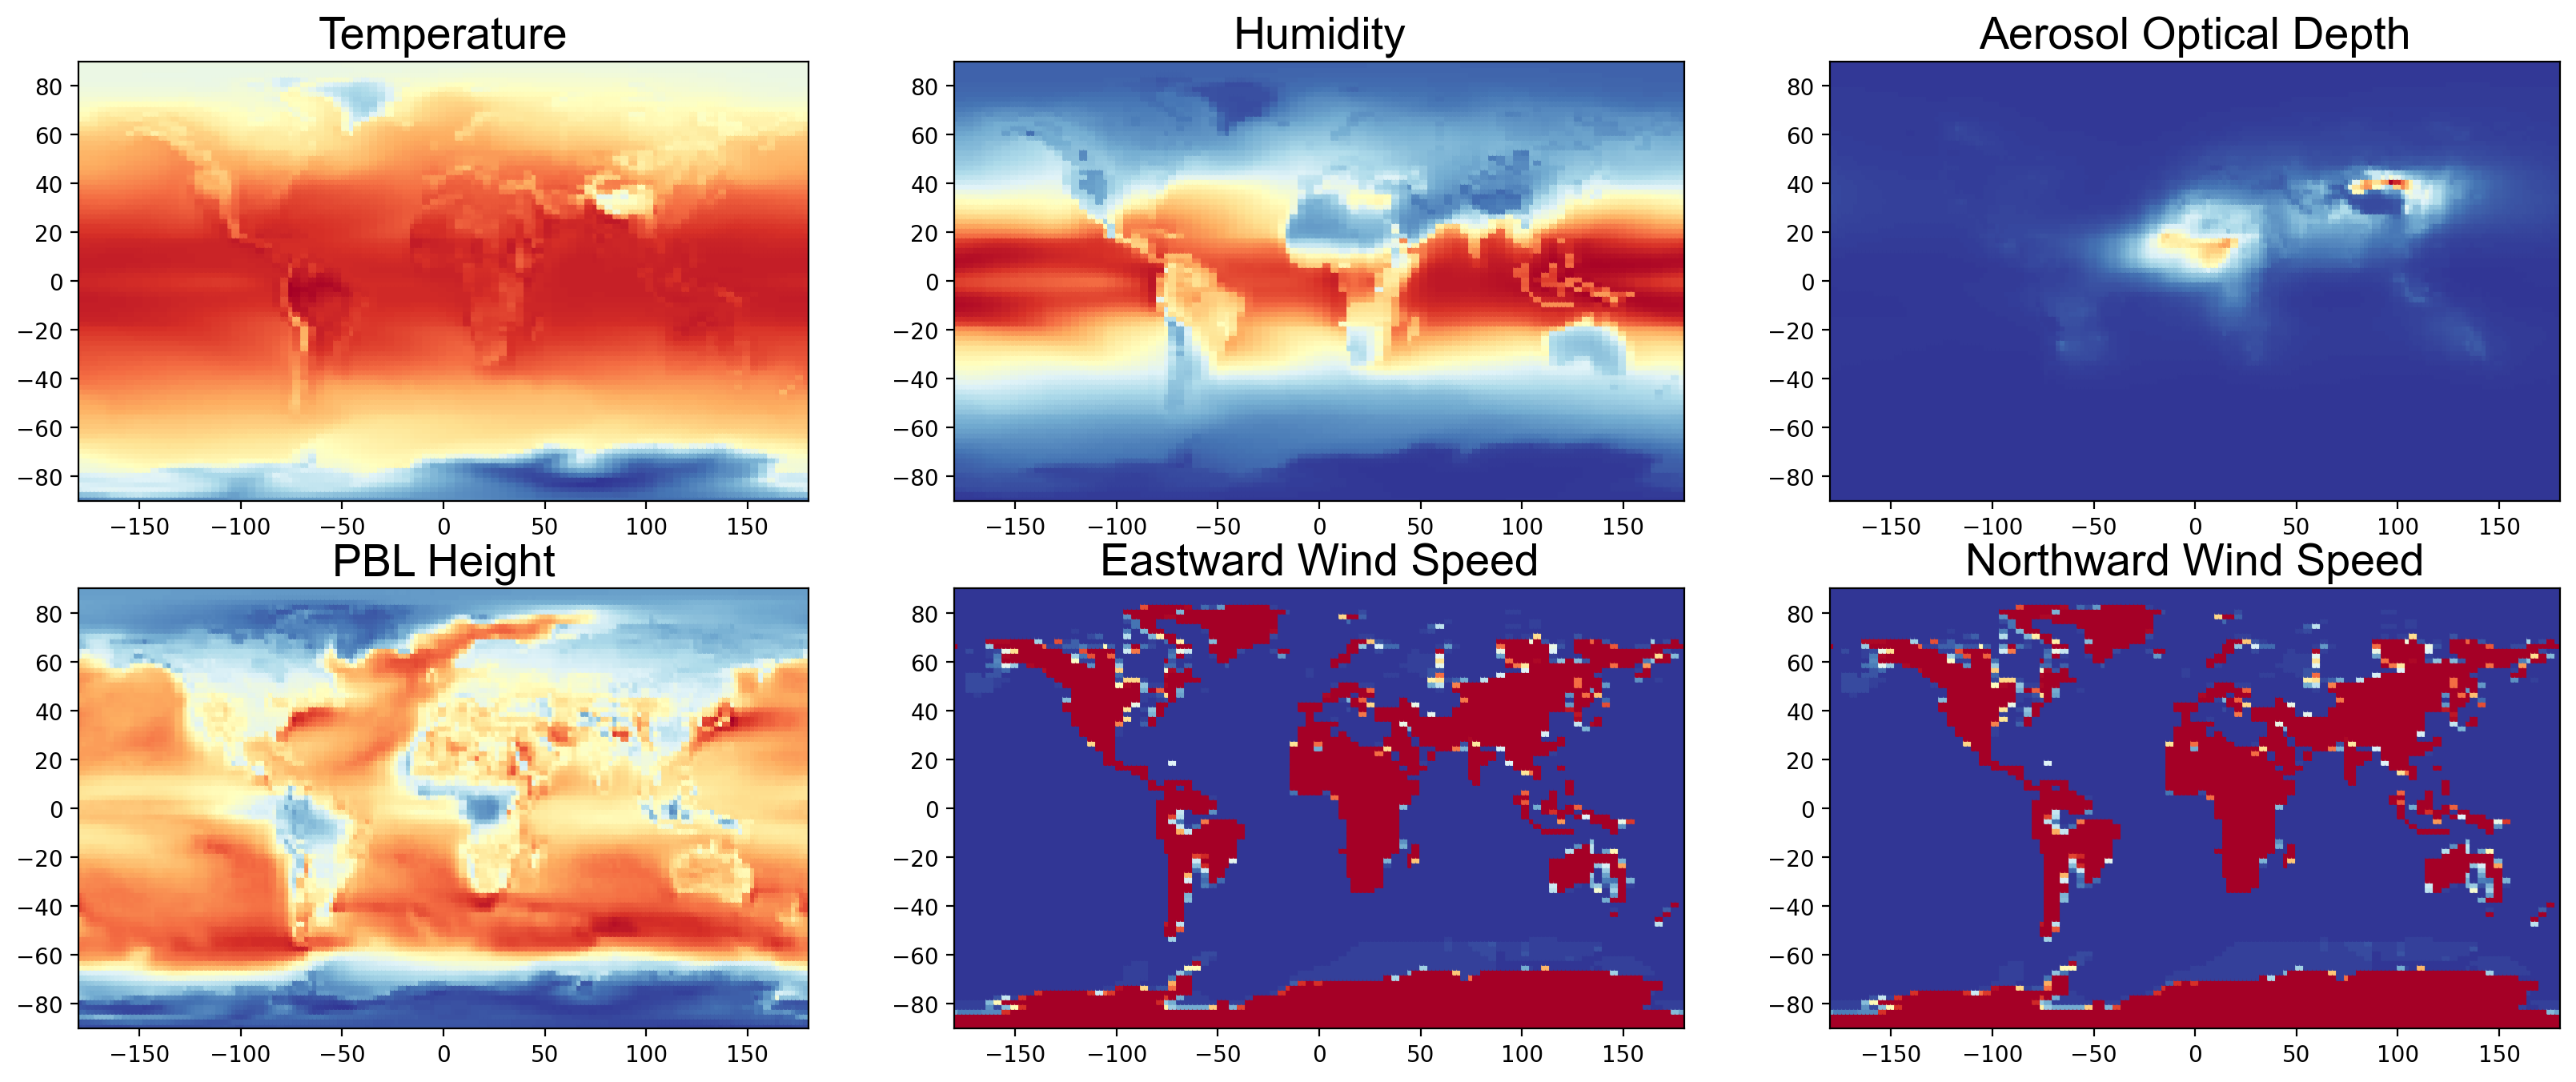

In [34]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('PBL Height', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['bldep'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

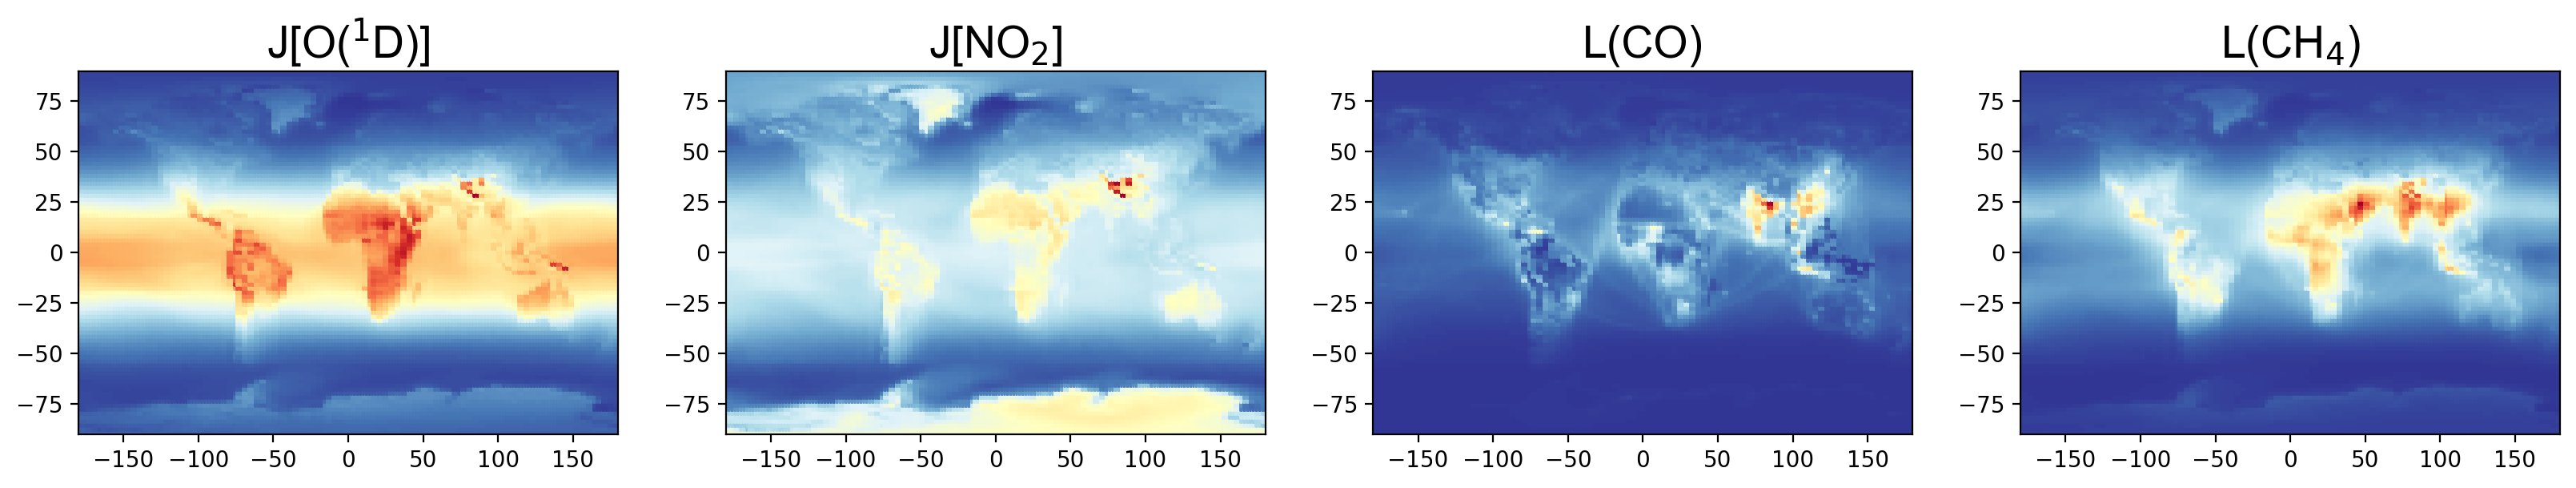

In [35]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

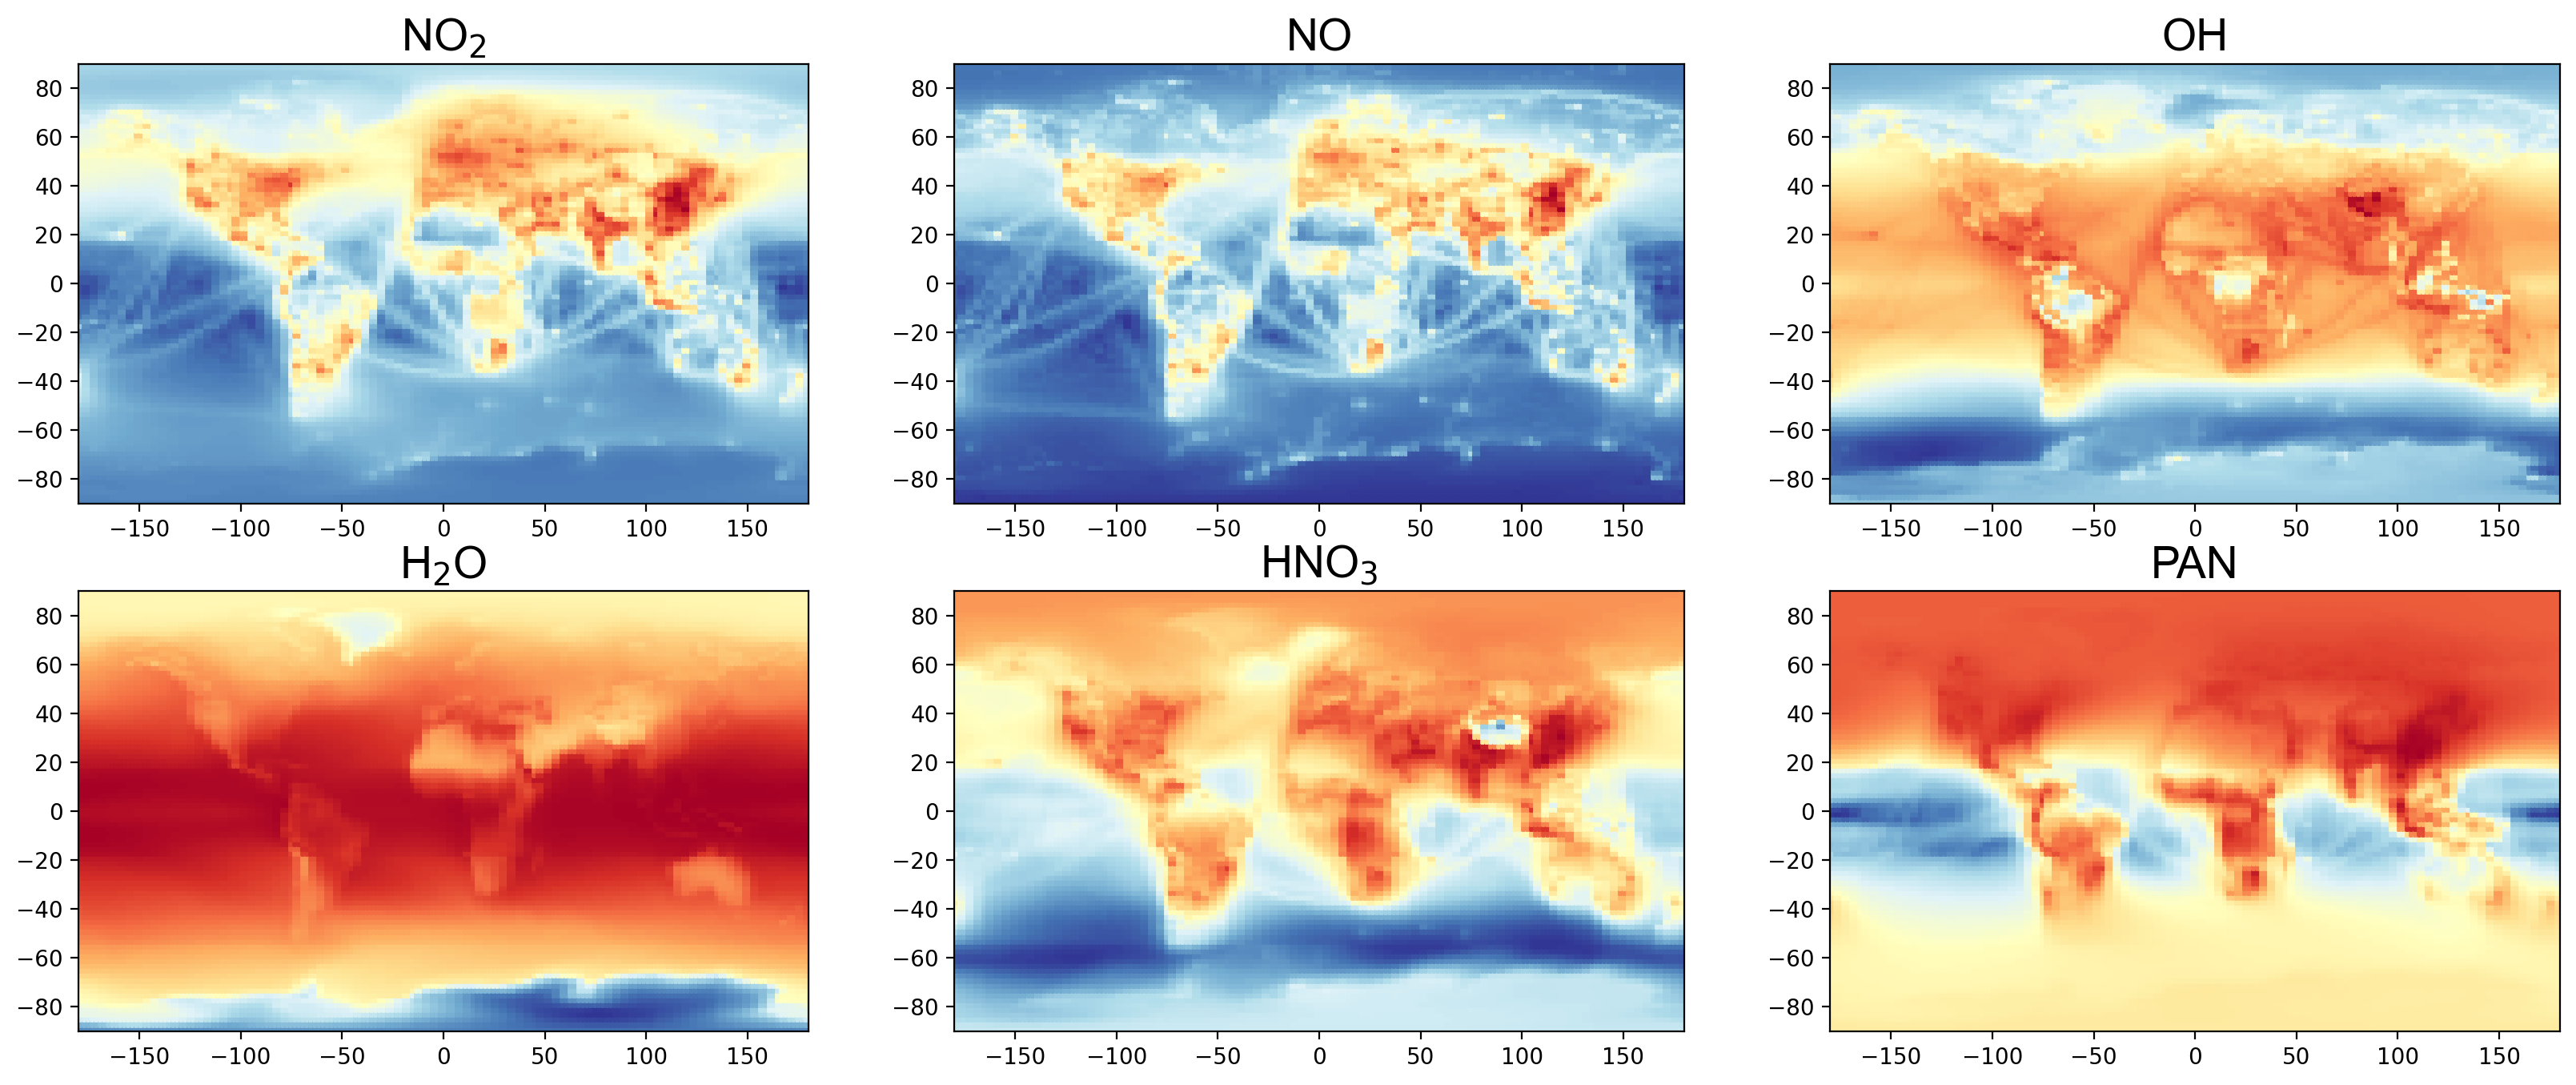

In [36]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('H${_2}$O', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['h2o'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### We should now check whether each variable has been correctly extracted without any erroneous values (e.g. negative concentrations), and the sample sizes are all year×12×lon×lat. 

In [37]:
dataset_adj['eminox'].describe()

count    9.720000e+05
mean     4.999411e-12
std      2.007447e-11
min      0.000000e+00
25%      1.905846e-14
50%      2.520263e-13
75%      1.987908e-12
max      6.233629e-10
Name: eminox, dtype: float64

In [38]:
dataset_adj['emivoc'].describe()

count    9.720000e+05
mean     3.563977e-11
std      1.237158e-10
min      0.000000e+00
25%      3.552848e-14
50%      3.737618e-13
75%      9.387523e-13
max      4.501220e-09
Name: emivoc, dtype: float64

In [39]:
dataset_adj['o3'].describe()

count    9.720000e+05
mean     1.966627e-08
std      8.888429e-09
min      3.539855e-09
25%      1.282744e-08
50%      1.751712e-08
75%      2.536974e-08
max      8.984055e-08
Name: o3, dtype: float64

In [40]:
dataset_adj['o3prod'].describe()

count    9.720000e+05
mean     1.360240e+06
std      3.156966e+06
min      1.090878e-07
25%      5.570737e+04
50%      2.904949e+05
75%      1.170094e+06
max      6.341945e+07
Name: o3prod, dtype: float64

In [41]:
dataset_adj['o3loss'].describe()

count    9.720000e+05
mean     4.845749e+05
std      6.771992e+05
min      5.669633e+00
25%      2.655389e+04
50%      1.918532e+05
75%      7.358806e+05
max      1.082378e+07
Name: o3loss, dtype: float64

In [42]:
dataset_adj['tas'].describe()

count    972000.000000
mean        278.891693
std          20.606461
min         204.327911
25%         268.240738
50%         282.862823
75%         296.403824
max         314.214905
Name: tas, dtype: float64

In [43]:
dataset_adj['hus'].describe()

count    972000.000000
mean          0.007148
std           0.005982
min           0.000038
25%           0.002178
50%           0.005220
75%           0.011770
max           0.021948
Name: hus, dtype: float64

In [44]:
dataset_adj['aod'].describe()

count    972000.000000
mean          0.002415
std           0.006715
min           0.000101
25%           0.000250
50%           0.000630
75%           0.001494
max           0.204349
Name: aod, dtype: float64

In [45]:
dataset_adj['bldep'].describe()

count    972000.000000
mean        979.383362
std         462.084167
min         118.427505
25%         570.535034
50%        1042.512207
75%        1321.503174
max        3398.785400
Name: bldep, dtype: float64

In [46]:
dataset_adj['ua'].describe()

count    9.720000e+05
mean     2.708280e+19
std               inf
min     -1.584960e+01
25%     -1.948379e+00
50%      1.983843e+00
75%      1.000000e+20
max      1.000000e+20
Name: ua, dtype: float64

In [47]:
dataset_adj['va'].describe()

count    9.720000e+05
mean     2.708280e+19
std               inf
min     -1.231295e+01
25%     -9.736356e-01
50%      1.177761e+00
75%      1.000000e+20
max      1.000000e+20
Name: va, dtype: float64

In [48]:
dataset_adj['jno2'].describe()

count    972000.000000
mean          0.002402
std           0.001772
min           0.000000
25%           0.001141
50%           0.002509
75%           0.003159
max           0.011694
Name: jno2, dtype: float64

In [49]:
dataset_adj['photo1d'].describe()

count    9.720000e+05
mean     5.397654e-06
std      4.970500e-06
min      0.000000e+00
25%      6.639215e-07
50%      3.940926e-06
75%      9.892218e-06
max      3.038311e-05
Name: photo1d, dtype: float64

In [50]:
dataset_adj['no2'].describe()

count    9.720000e+05
mean     3.214221e-10
std      1.092987e-09
min      3.760039e-13
25%      1.402622e-11
50%      4.082940e-11
75%      1.768921e-10
max      2.708142e-08
Name: no2, dtype: float64

In [51]:
dataset_adj['no'].describe()

count    9.720000e+05
mean     8.930063e-11
std      5.391979e-10
min      3.102983e-22
25%      2.664689e-12
50%      7.605408e-12
75%      3.315361e-11
max      3.993997e-08
Name: no, dtype: float64

In [52]:
dataset_adj['oh'].describe()

count    9.720000e+05
mean     3.874450e-14
std      4.382905e-14
min      2.351827e-19
25%      4.173234e-15
50%      2.186482e-14
75%      6.378063e-14
max      8.350719e-13
Name: oh, dtype: float64

In [53]:
dataset_adj['h2o'].describe()

count    972000.000000
mean          0.011664
std           0.009749
min           0.000023
25%           0.003580
50%           0.008562
75%           0.019307
max           0.035328
Name: h2o, dtype: float64

In [54]:
dataset_adj['hno3'].describe()

count    9.720000e+05
mean     1.163980e-10
std      2.710072e-10
min      5.876638e-15
25%      5.495293e-12
50%      1.780100e-11
75%      9.219156e-11
max      6.938174e-09
Name: hno3, dtype: float64

In [55]:
dataset_adj['pan'].describe()

count    9.720000e+05
mean     8.210205e-11
std      1.262993e-10
min      1.485236e-14
25%      5.316640e-12
50%      1.563965e-11
75%      1.381395e-10
max      3.318683e-09
Name: pan, dtype: float64

In [56]:
dataset_adj['lossco'].describe()

count    9.720000e+05
mean     4.328578e+05
std      5.851648e+05
min      9.216076e-01
25%      3.775770e+04
50%      2.372888e+05
75%      6.183526e+05
max      1.119694e+07
Name: lossco, dtype: float64

In [57]:
dataset_adj['lossch4'].describe()

count    9.720000e+05
mean     3.178630e+00
std      3.582165e+00
min      2.313973e-18
25%      3.675472e-01
50%      2.154741e+00
75%      4.687558e+00
max      3.556559e+01
Name: lossch4, dtype: float64

#### We should then check the scale of the kinetic rate coefficients with the IUPAC suggested values. 

##### The preferred value as 8.5×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [58]:
dataset_adj['k_no_ho2'].median()

8.571551227569579e-12

##### The preferred value as 7.7×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [59]:
dataset_adj['k_no_ch3o2'].median()

8.21211850643158e-12

##### The preferred value as 2.14×10$^{–10}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [60]:
dataset_adj['k_o1d_h2o'].median()

2.0151567447185517e-10

##### The preferred value as 2.0×10$^{–15}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [61]:
dataset_adj['k_o3_ho2'].median()

1.797851070566387e-15

##### The preferred value as 7.3×10$^{–14}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [62]:
dataset_adj['k_o3_oh'].median()

6.126556284725666e-14